Comparison of the energies for the uniform and cycloidal solution of a one-dimensional system with DMI

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('lato_style.mplstyle')

import pandas as pd
from IPython.display import Image

# 1D Problem

One dimensional standard problem for the *Proposal for a micromagnetic standard problem for materials with Dzyaloshinskii-Moriya interaction* paper.

System:


    * A permalloy-like 1D wire of 100 nm x 1 nm x 1 nm (x,y,z)
    * Interactions: Exchange:                      13  pJ m**-1
                    DMI:                            3  mJ m**-2
                    Uniaxial Anisotropy along z:  0.4  MJ m**-3
                    Ms:                          0.86  A / m  

We will solve and simulate the system using interfacial ($C_{nv}$), bulk ($T$) and $D_{2d}$ DMI 

In [3]:
# System parameters
# nm = 1e-9
# L = 100 * nm      # sample length in nm
# l = L / nm        # scale in nm

# Permalloy-like material (for testing purposes)
A = 13e-12
D = 3e-3
Ku = 0.4e6
Ms = 0.86e6

In [4]:
# Exchange and helical lengths:
mu0 = 4 * np.pi * 1e-7
lex = np.sqrt(2 * A / (mu0 * Ms ** 2))
lD = 4 * np.pi * A / D
print('L_ex =', lex * 1e9, 'nm')
print('L_D =', lD * 1e9, 'nm')

L_ex = 5.289118420310732 nm
L_D = 54.454272662223076 nm


# FIDIMAG Simulation

In [6]:
import fidimag

Ferromagnetic solution:

In [86]:
%%capture

dx, dy, dz = 1, 1, 1

sys = {}
for l in np.arange(20, 131, 5):
    
    nx, ny, nz = int(l / dx), 1, 1
    mesh = fidimag.common.CuboidMesh(dx=dx, dy=dy, dz=dz, nx=nx, ny=ny, nz=nz,
                                     unit_length=1e-9)

    sim = fidimag.micro.Sim(mesh, name='fidimag_1D_' + str(l))
    sim.Ms = Ms
    sim.set_m((-0.1, 0, 0.9))
    sim.add(fidimag.micro.UniformExchange(A=A))
    sim.add(fidimag.micro.UniaxialAnisotropy(Ku, axis=(0, 0, 1)))
    sim.add(fidimag.micro.DMI(D=D, dmi_type='interfacial'))

    sim.driver.do_precession = False
    sim.driver.alpha = 0.9
    sim.relax(stopping_dmdt=0.01)

    # -----------------------------------------------------------------------------

    r_fidimag = mesh.coordinates
    sys[l] = [None for i in range(4)]
    sys[l][0] = sim.spin.reshape(-1, 3)[:, 0]
    sys[l][1] = sim.spin.reshape(-1, 3)[:, 1]
    sys[l][2] = sim.spin.reshape(-1, 3)[:, 2]
    
    # Energy
    sys[l][3] = sim.compute_energy()

Cycloidal solution:

In [82]:
def cyc(r, centre):
    if r[0] < centre:
        return (0, 0, -1)
    else:
        return (0, 0, 1)

In [87]:
%%capture

dx, dy, dz = 1, 1, 1

sys_cyc = {}
for l in np.arange(20, 131, 5):
    
    nx, ny, nz = int(l / dx), 1, 1
    mesh = fidimag.common.CuboidMesh(dx=dx, dy=dy, dz=dz, nx=nx, ny=ny, nz=nz,
                                     unit_length=1e-9)

    sim = fidimag.micro.Sim(mesh, name='fidimag_1D_' + str(l))
    sim.Ms = Ms
    sim.set_m(lambda r: cyc(r, centre=l * 0.5))
    sim.add(fidimag.micro.UniformExchange(A=A))
    sim.add(fidimag.micro.UniaxialAnisotropy(Ku, axis=(0, 0, 1)))
    sim.add(fidimag.micro.DMI(D=D, dmi_type='interfacial'))

    sim.driver.do_precession = False
    sim.driver.alpha = 0.9
    sim.relax(stopping_dmdt=0.01)

    # -----------------------------------------------------------------------------

    r_fidimag = mesh.coordinates
    sys_cyc[l] = [None for i in range(4)]
    sys_cyc[l][0] = sim.spin.reshape(-1, 3)[:, 0]
    sys_cyc[l][1] = sim.spin.reshape(-1, 3)[:, 1]
    sys_cyc[l][2] = sim.spin.reshape(-1, 3)[:, 2]
    
    # Energy
    sys_cyc[l][3] = sim.compute_energy()

Then relax the system and plot the solutions:

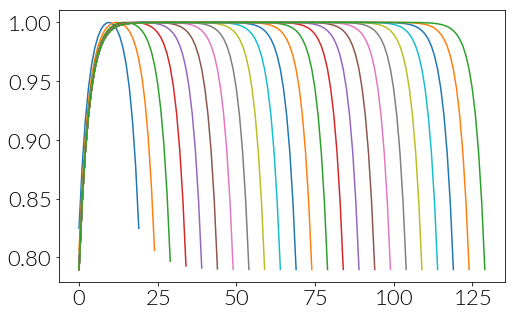

In [89]:
for l in np.arange(20, 131, 5):
    plt.plot(sys[l][2], label='interfacial')


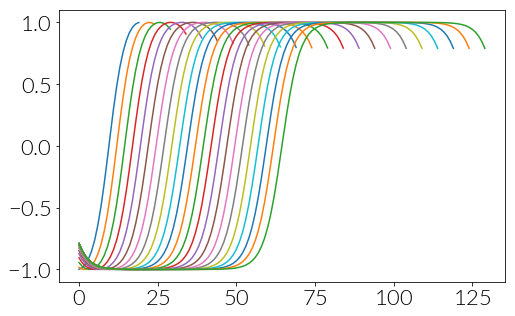

In [90]:
for l in np.arange(20, 131, 5):
    plt.plot(sys_cyc[l][2], label='interfacial')


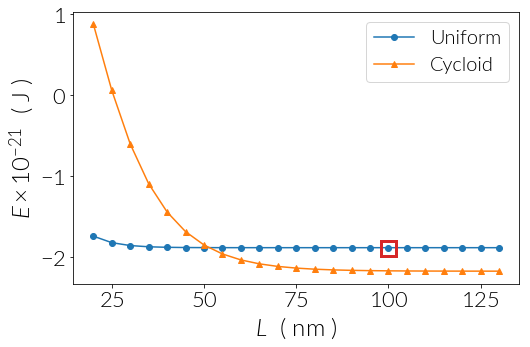

In [123]:
sol_FM = []
for l in np.arange(20, 131, 5):
    sol_FM.append([l, sys[l][3] * 10 ** 21])
sol_FM = np.array(sol_FM)
    
plt.plot(sol_FM[:, 0], sol_FM[:, 1], 'o-C0', label='Uniform')
    
sol_cyc = []
for l in np.arange(20, 131, 5):
    sol_cyc.append([l, sys_cyc[l][3] * 10 ** 21])
sol_cyc = np.array(sol_cyc)
    
plt.plot(sol_cyc[:, 0], sol_cyc[:, 1], '^-C1', label='Cycloid')
    
plt.xlabel(r'$L$  ( nm )')
plt.ylabel(r'$E \times 10^{-21}$  ( J )')
plt.legend()

plt.plot(sol_FM[16, 0], sol_FM[16, 1], 'sC3', ms=15, markerfacecolor='None', mew=3)

plt.savefig('./result_1d_solutions_energy_comp.pdf', bbox_inches='tight')